# Analiza przekazu medialnego na temat społeczności LGBT na przykładach portali internetowych

## Do analizy zostało wybranych 10 różnorodnych portali, zarówno newsowych jak i opiniotwórczych. Zróżnicowane jest także położenie ideologiczne. Na liście są zarówno portale lewicowe, liberalne i prawicowe a także dwa portale katolickie położone na dwóch ideologicznych biegunach

### Cele analizy: identyfikacja najczęściej używanych wyrazów, najczęstszych współwystępowań słów, częstotliwości występowania wybranych słów nacechowanych pozytywnie i negatywnie, związanych z empatią/troską oraz z wrogością a także identyfikacja potencjalnych metafor. Na tej podstawie sformułowane zostaną wnioski dotyczące nastawienia portalu w stosunku do społeczności LGBT.

### 1. Reading data and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS 
from langdetect import detect
import spacy
import random
from collections import Counter
import nltk
from nltk.collocations import *
import datetime
import re
import pprint

In [2]:
# reading data
data_wpolityce = pd.read_csv(r"wpolityce1.csv").dropna().reset_index().drop("index",axis=1)
data_oko = pd.read_csv(r"oko.csv").dropna().reset_index().drop("index",axis=1)
data_niezalezna = pd.read_csv(r"niezalezna.csv").dropna().reset_index().drop("index",axis=1)
data_krypol = pd.read_csv(r"krypol.csv").dropna().reset_index().drop("index",axis=1)
data_kj = pd.read_csv(r"kj.csv").dropna().reset_index().drop("index",axis=1)
data_gazeta = pd.read_csv(r"gazetapeel.csv",lineterminator="\n").dropna().reset_index().drop("index",axis=1)
data_kontakt = pd.read_csv(r"kontakt.csv").dropna().reset_index().drop("index",axis=1)
data_super_express = pd.read_csv(r"se.csv",lineterminator="\n").dropna().reset_index().drop("index",axis=1)
data_pch24 = pd.read_csv(r"pch241.csv",encoding="utf8").dropna().reset_index().drop("index",axis=1)

In [3]:
data_oko.drop(131,axis=0,inplace=True)

In [4]:
data_oko = data_oko.reset_index().drop("index",axis=1)

In [5]:
#removing authors bio

for i in range(len(data_oko.Content)):
    data_oko.Content[i] = str(data_oko.Content[i].split(".")[:-6])


#### Parsing dates to datetime format

In [6]:
# changing dates in dataframes to a common format
# wpolityce.pl - iso format
for i in range(len(data_wpolityce.Date)):
    data_wpolityce.Date[i] = datetime.date.fromisoformat(data_wpolityce.Date[i])

In [7]:
# oko.press 01 Stycznia 2020 format
dict_months = {"stycznia":"01","styczeń":"01",
              "lutego":"02","luty":"02",
              "marca":"03", "marzec":"03",
              "kwietnia":"04","kwiecień":"04",
              "maja":"05","maj":"05",
              "czerwca":"06","czerwiec":"06",
              "lipca":"07","lipiec":"07",
              "sierpnia":"08","sierpień":"08",
              "września":"09","wrzesień":"09",
              "października":"10","październik":"10",
              "listopada":"11","listopad":"11",
              "grudnia":"12","grudzień":"12",
              "February":"2","June":"6","May":"5","August":"8"}

for i in range(len(data_oko.Date)):
    data_oko.Date[i] = data_oko.Date[i].replace(re.search(r"\D+",data_oko.Date[i]).group().strip(),dict_months[re.search(r"\D+",data_oko.Date[i]).group().strip()])
    data_oko.Date[i] = datetime.datetime.strptime(data_oko.Date[i],"%d %m %Y")
data_oko.Date[0]

datetime.datetime(2020, 2, 20, 0, 0)

In [8]:
# niezalezna dd.mm.yyyy format
for i in range(len(data_niezalezna.Date)):
    data_niezalezna.Date[i] = datetime.datetime.strptime(data_niezalezna.Date[i],"%d.%m.%Y")
data_niezalezna.Date[0]

datetime.datetime(2020, 12, 14, 0, 0)

In [9]:
# same as oko, but first texts are dated as "dwa dni temu"
for i in range(2,len(data_krypol.Date)):
    data_krypol.Date[i] = data_krypol.Date[i].replace(re.search(r"\D+",data_krypol.Date[i]).group().strip(),dict_months[re.search(r"\D+",data_krypol.Date[i]).group().strip()])
    data_krypol.Date[i] = datetime.datetime.strptime(data_krypol.Date[i],"%d %m %Y")

In [10]:
data_krypol.Date[0] = datetime.datetime(2020, 12, 26, 0, 0)
data_krypol.Date[1] = datetime.datetime(2020, 12, 21, 0, 0)


In [11]:
# same as oko
for i in range(len(data_kj.Date)):
    data_kj.Date[i] = data_kj.Date[i].replace(re.search(r"\D+",data_kj.Date[i]).group().strip(),dict_months[re.search(r"\D+",data_kj.Date[i]).group().strip()])
    data_kj.Date[i] = datetime.datetime.strptime(data_kj.Date[i],"%d %m %Y")
data_kj.Date[0]

datetime.datetime(2020, 8, 8, 0, 0)

In [12]:
# gazeta.pl, as niezalezna but with hour
for i in range(len(data_gazeta.Date)):
    data_gazeta.Date[i] = datetime.datetime.strptime(data_gazeta.Date[i],"%d.%m.%Y  %H:%M")
data_gazeta.Date[0]

datetime.datetime(2020, 12, 21, 14, 26)

In [13]:
# kontakt, same as klub jagiellonski
for i in range(len(data_kontakt.Date)):
    data_kontakt.Date[i] = data_kontakt.Date[i].replace(re.search(r"\D+",data_kontakt.Date[i]).group().strip(),dict_months[re.search(r"\D+",data_kontakt.Date[i]).group().strip()])
    data_kontakt.Date[i] = datetime.datetime.strptime(data_kontakt.Date[i],"%d %m %Y")
data_kontakt.Date[0]

datetime.datetime(2020, 9, 9, 0, 0)

In [14]:
for i in range(len(data_super_express.Date)):
    data_super_express.Date[i] = datetime.datetime.strptime(data_super_express.Date[i],"%Y-%m-%d")
data_super_express.Date[0]

datetime.datetime(2020, 12, 14, 0, 0)

In [15]:
for i in range(len(data_pch24.Date)):
    try:
        data_pch24.Date[i] = datetime.datetime.strptime(data_pch24.Date[i].replace("DATA: ",""),"%Y-%m-%d %H:%M:%S")
    except:
        data_pch24.Date[i] = datetime.datetime.strptime(data_pch24.Date[i].replace("DATA: ",""),"%Y-%m-%d %H:%M")
        
data_pch24.Date[0]

datetime.datetime(2020, 1, 2, 21, 30)

In [16]:
data_dict = {"wPolityce.pl":data_wpolityce,
             "OKO.press" : data_oko,
             "Niezalezna.pl":data_niezalezna,
             "Krytyka_Polityczna":data_krypol,
             "Klub_Jagiellonski":data_kj,
             "Gazeta.pl":data_gazeta,
             "Kontakt":data_kontakt,
             "Super_Express":data_super_express,
             "Pch24.pl":data_pch24}
punctuation = ["/",".",":",",",")","(","\"","_","-","?","!","...","„","”","–","—","…","[","]","^","'"]
for key in data_dict:
    for i in range(len(data_dict[key].Content)):    
        for sign in punctuation:
            data_dict[key].Content[i] = data_dict[key].Content[i].replace(sign,"")
            data_dict[key].Content[i] = data_dict[key].Content[i].replace("  "," ")


### 2. Exploratory analysis

#### 2.1 Plots showing number of articles on lgbt issues published throughout the year

<ipython-input-46-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


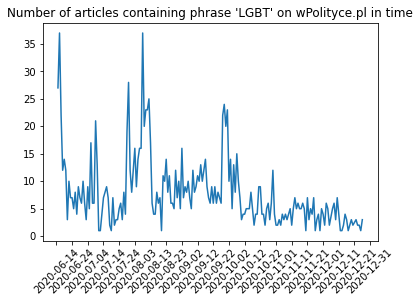

<ipython-input-46-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


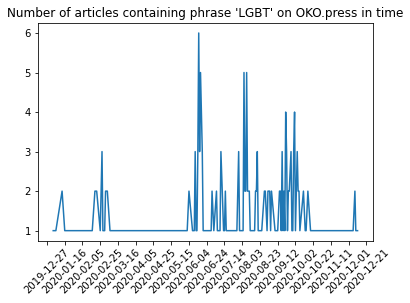

<ipython-input-46-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


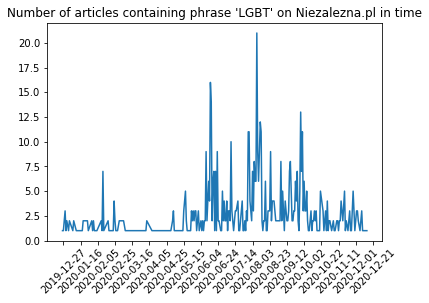

<ipython-input-46-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


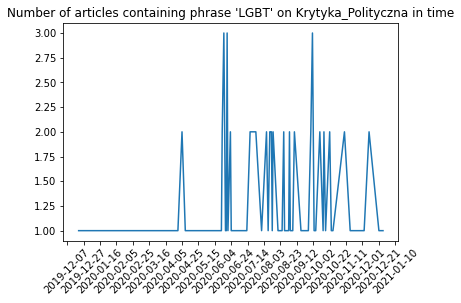

<ipython-input-46-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


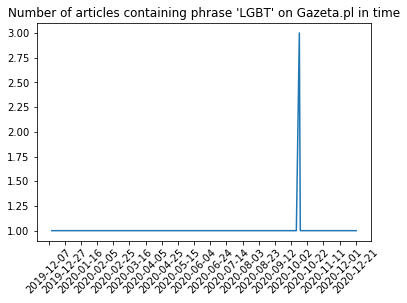

<ipython-input-46-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


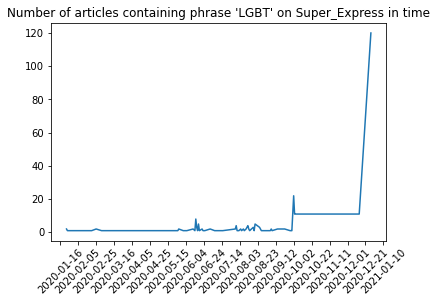

<ipython-input-46-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


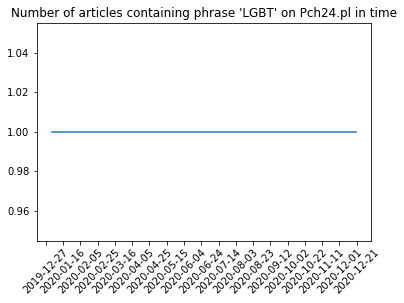

In [46]:

keys = list(data_dict.keys())
for i in range(len(data_dict)):
    if len(data_dict[keys[i]].Content)>100:
        frame = data_dict[keys[i]].sort_values(by="Date")
        grouped = frame.groupby("Date").size()
        plt.plot(grouped.index,grouped.values)
        plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))
        plt.xticks(rotation=45)
        plt.title(f"Number of articles containing phrase 'LGBT' on {keys[i]} in time")
        plt.show()

#### 2.1 Summary

Charts show couple of "hot" points during the year, where most of the articles were published. They are most visible in data from sites with most publicatons in corpus, mainly wPolityce.pl. These spots are generally consistent with major events in polish public debate. May peak corresponds with planned first round of presidential election, june and july ones happen around actual dates of first and second presidential vote. One from late august corresponds with the arrest of LGBT+ activist Margot and subsequent protests. Peaks around late october were caused by lbgt+ community participation in protests against tightening anti-abortion laws in poland

#### 2.2 Preprocessing for NLP with Spacy and creating word clouds

In [127]:
# loading spacy model for polish 
nlp = spacy.load("pl_core_news_md")

In [128]:
# creating a column containing text processed by spacy in each data frame 
for key in data_dict:
    data_dict[key]["processed"] = 0
    for i in range(len(data_dict[key].Content)):
        data_dict[key]["processed"][i] = nlp(data_dict[key].Content[i])

<ipython-input-128-25d2972400cd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[key]["processed"][i] = nlp(data_dict[key].Content[i])
C:\Users\szklarnia\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [33]:
# reading and updating stopwords list for polish
f = open("polish.stopwords.txt","r",encoding="utf8")
stopwords = f.readlines()
stopwords = [x.replace("\n","") for x in stopwords]
adds = ["mieć","zostać","móc","pisać","chcieć","czytać"]
stopwords = stopwords + adds
f.close()
stopwords = set(stopwords)

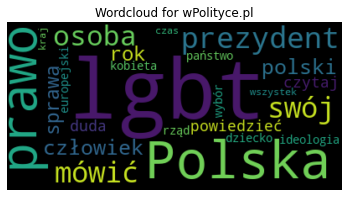

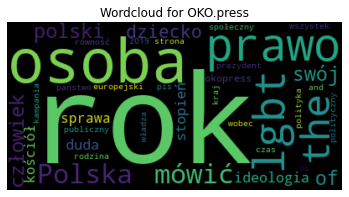

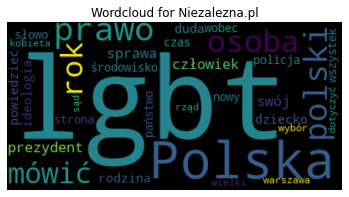

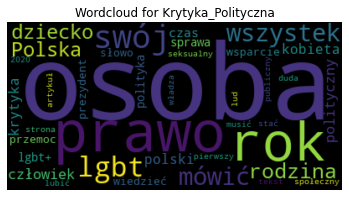

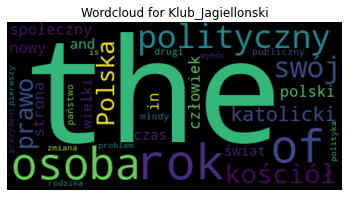

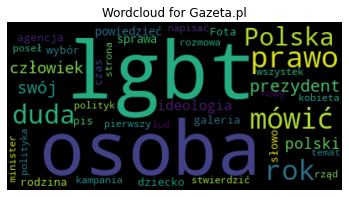

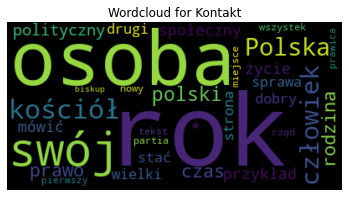

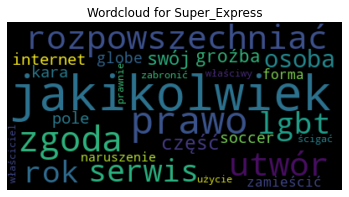

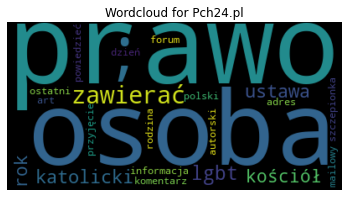

In [34]:
# creating word clouds for each data frame
# dictionary to save frequencies for further analysis
frequency = {}
# reading processed data from each data frame, creating variables
for key in data_dict:
    content = data_dict[key].processed
    lemmas_all = []
    frequencies = {}
    # reading lemmas for each text and combining them into one list
    for text in content:
        lemmas = [token.lemma_ for token in text]
        lemmas_all = lemmas_all + lemmas
    # creating frequency table for each lemma in texts
    values, counts = np.unique(lemmas_all, return_counts=True)
    for i in range(len(values)):
        frequencies[values[i]] = counts[i]
    # erasing stopwords from frequencies dictionary
    for word in stopwords:
        frequencies.pop(word,None)

    frequency[key] = frequencies
    # creating word cloud from frequencies
    wordcloud = WordCloud(min_font_size=10).generate_from_frequencies(frequencies)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off")
    plt.title(f"Wordcloud for {key}")
    plt.show()

In [35]:
pd.Series(frequency["wPolityce.pl"]).sort_values(ascending=False).head(50)

               12281
                4266
lgbt            3587
Polska          2869
prawo           2563
prezydent       2186
swój            2014
mówić           1983
osoba           1871
człowiek        1777
polski          1771
rok             1646
sprawa          1516
powiedzieć      1371
duda            1357
czytaj          1328
ideologia       1162
dziecko         1146
rząd            1121
państwo         1044
europejski      1026
wybór           1009
kobieta          990
wszystek         987
kraj             981
czas             955
polityczny       948
nowy             942
pis              924
strona           921
aktywista        888
środowisko       867
rodzina          854
wielki           844
trzaskowski      840
słowo            834
wobec            762
działanie        746
wyborczy         746
kościół          723
warszawa         720
władza           715
musić            707
sytuacja         697
medium           692
stać             682
policja          681
wiedzieć     

In [79]:
pd.Series(frequency["OKO.press"]).sort_values(ascending=False).head(50)

              3224
rok           2065
osoba         1716
prawo         1626
lgbt          1473
the           1238
Polska         925
mówić          923
polski         895
człowiek       885
swój           832
of             814
dziecko        663
ideologia      634
duda           632
stopień        626
sprawa         577
kościół        550
okopress       524
prezydent      524
ii             512
pis            504
państwo        477
rodzina        468
europejski     467
czas           455
wszystek       440
and            414
władza         412
społeczny      392
publiczny      378
równość        372
2019           365
kraj           358
polityczny     357
polityka       349
kampania       347
strona         345
wobec          342
powiedzieć     334
słowo          334
działanie      333
sąd            326
pierwszy       321
wybór          320
miasto         319
wielki         317
wydział        317
medium         312
kobieta        310
dtype: int64

#### 2.3 Looking for common collocations

In [126]:
# creating a dictionary for collocations in each data frame

collocations = {}
# reading tokens from processed data for each data frame
for key in data_dict:
    all_tokens = []
    for text in data_dict[key].processed:
        tokens = [token.lemma_.lower() for token in text]
        all_tokens = all_tokens + tokens
    # finding collocations
    #reading measures
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    # finding collocations using BigramCollocationsFinder from NLTK
    finder = BigramCollocationFinder.from_words(all_tokens)
    # filtering out collocations containing stopwords
    finder.apply_word_filter(lambda w: w in stopwords)

    # applying right frequency filters based on set size
    if len(data_dict[key].processed) > 500:
        finder.apply_freq_filter(50)
    elif len(data_dict[key].processed) > 100 and len(data_dict[key].processed)<500:
        finder.apply_freq_filter(20)
    elif len(data_dict[key].processed) < 100:
        finder.apply_freq_filter(5)
    # creating a dictionary containing collocations and their frequencies
    scored = dict(finder.score_ngrams(bigram_measures.raw_freq))
    # switching to real occurence numbers
    scored.update((x, (y*len(all_tokens),y)) for x, y in scored.items())
    # appending collocations dictionary for currently processed data frame
    collocations[key] = scored

AttributeError: 'DataFrame' object has no attribute 'processed'

In [72]:
for key in collocations:
    print(f"Common collocations for {key}")
    for attribute, value in collocations[key].items():
        print(f"{attribute}:{value}")
    print("\n\n ---------------------------")


Common collocations for wPolityce.pl
('andrzej', 'duda'):(863.0, 0.001240295371384388)
('aktywista', 'lgbt'):(556.0, 0.0007990778985975895)
('ideologia', 'lgbt'):(464.0, 0.0006668563758080603)
('michał', 'sz'):(416.0, 0.0005978712334830886)
('rafały', 'trzaskowski'):(381.0, 0.0005475695672044633)
('prezydent', 'andrzej'):(360.0, 0.0005173885674372882)
('  ', 'mówić'):(345.00000000000006, 0.0004958307104607346)
('środowisko', 'lgbt'):(324.0, 0.0004656497106935594)
('prawo', 'człowiek'):(314.0, 0.0004512778060425236)
(' ', 'powiedzieć'):(312.0, 0.00044840342511231644)
('  ', 'powiedzieć'):(294.0, 0.000422533996740452)
('rafał', 'trzaskowski'):(294.0, 0.000422533996740452)
('osoba', 'lgbt'):(289.0, 0.00041534804441493414)
('strefa', 'wolny'):(276.0, 0.0003966645683685876)
('gazeta', 'wyborczy'):(268.0, 0.00038516704464775897)
(' ', 'mówić'):(266.0, 0.00038229266371755184)
('prezydent', 'duda'):(247.0, 0.00035498604488058385)
('unia', 'europejski'):(240.0, 0.0003449257116248588)
('tęczowy'

In [103]:
# creating trigram collocations
# defining punctuation, creating a dictionary for collocations in each data frame
collocations_trigram = {}

# reading tokens from processed data in each data frame
for key in data_dict:
    all_tokens = []
    for text in data_dict[key].processed:
        tokens = [token.lemma_.lower() for token in text]
        all_tokens = all_tokens + tokens
   
    #reading measures
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    
    # finding collocations using TrigramCollocationsFinder from NLTK
    finder = TrigramCollocationFinder.from_words(all_tokens,window_size=3)
    
    # filtering out collocations containing stopwords and punctuation
    finder.apply_word_filter(lambda w: w in stopwords)
    
    # applying right frequency filters based on set size
    if len(data_dict[key].processed) > 500:
        finder.apply_freq_filter(20)
    elif len(data_dict[key].processed) < 500:
        finder.apply_freq_filter(5)
    # switching to real occurence numbers

    scored = dict(finder.score_ngrams(trigram_measures.raw_freq))
    scored.update((x, (y*len(all_tokens),y)) for x, y in scored.items())
    collocations_trigram[key] = scored

AttributeError: 'DataFrame' object has no attribute 'processed'

In [95]:
for key in collocations_trigram:
    print(f"Common collocations for {key}")
    for attribute, value in collocations_trigram[key].items():
        print(f"{attribute}:{value}")
    print("\n\n ---------------------------")


Common collocations for wPolityce.pl
('prezydent', 'andrzej', 'duda'):(359.0, 0.0005159513769721846)
('jan', 'paweł', 'ii'):(120.99999999999999, 0.00017390004627753297)
('rzecznik', 'prawo', 'obywatelski'):(107.99999999999999, 0.00015521657023118645)
('von', 'dera', 'leyen'):(83.0, 0.000119286808603597)
('michał', 'sz', 'margot'):(68.0, 9.772895162704333e-05)
('łódzki', 'kurator', 'oświata'):(62.99999999999999, 9.054299930152543e-05)
('prawo', 'osoba', 'lgbt'):(49.0, 7.042233279007533e-05)
('premiera', 'mateusz', 'morawiecki'):(48.0, 6.898514232497176e-05)
('ii', 'wojna', 'światowy'):(47.0, 6.754795185986818e-05)
('tura', 'wybór', 'prezydencki'):(47.0, 6.754795185986818e-05)
('zły', 'strona', 'historia'):(47.0, 6.754795185986818e-05)
('ideologia', 'lgbt', ' '):(45.0, 6.467357092966102e-05)
('mówić', 'portal', 'wpolitycepl'):(45.0, 6.467357092966102e-05)
('  ', 'dodać', ' '):(43.0, 6.179918999945387e-05)
('jany', 'pawła', 'ii'):(43.0, 6.179918999945387e-05)
('św', 'jan', 'paweł'):(43.0,

In [110]:
collocations["wPolityce.pl"]

{('andrzej', 'duda'): (863.0, 0.001240295371384388),
 ('aktywista', 'lgbt'): (556.0, 0.0007990778985975895),
 ('ideologia', 'lgbt'): (464.0, 0.0006668563758080603),
 ('michał', 'sz'): (416.0, 0.0005978712334830886),
 ('rafały', 'trzaskowski'): (381.0, 0.0005475695672044633),
 ('prezydent', 'andrzej'): (360.0, 0.0005173885674372882),
 ('  ', 'mówić'): (345.00000000000006, 0.0004958307104607346),
 ('środowisko', 'lgbt'): (324.0, 0.0004656497106935594),
 ('prawo', 'człowiek'): (314.0, 0.0004512778060425236),
 (' ', 'powiedzieć'): (312.0, 0.00044840342511231644),
 ('  ', 'powiedzieć'): (294.0, 0.000422533996740452),
 ('rafał', 'trzaskowski'): (294.0, 0.000422533996740452),
 ('osoba', 'lgbt'): (289.0, 0.00041534804441493414),
 ('strefa', 'wolny'): (276.0, 0.0003966645683685876),
 ('gazeta', 'wyborczy'): (268.0, 0.00038516704464775897),
 (' ', 'mówić'): (266.0, 0.00038229266371755184),
 ('prezydent', 'duda'): (247.0, 0.00035498604488058385),
 ('unia', 'europejski'): (240.0, 0.000344925711624

##### 2.3.2 Looking for collocations with the term LGBT

In [180]:
# looking for collocations with lgbt related terms
lgbt_filter = lambda *w: 'lgbt' not in w

collocations_lgbt = {}
# reading tokens from processed data for each data frame
for key in data_dict:
    all_tokens = []
    for text in data_dict[key].processed:
        tokens = [token.lemma_.lower() for token in text]
        all_tokens = all_tokens + tokens
    # finding collocations
    #reading measures
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    # finding collocations using BigramCollocationsFinder from NLTK
    finder = BigramCollocationFinder.from_words(all_tokens,window_size=3)
    # filtering out collocations containing stopwords
    finder.apply_word_filter(lambda w: w in stopwords)
    finder.apply_ngram_filter(lgbt_filter)
    if len(data_dict[key].processed) > 100:
        finder.apply_freq_filter(10)
    # creating a dictionary containing collocations and their frequencies
    scored = dict(finder.score_ngrams(bigram_measures.raw_freq))
    # switching to real occurence numbers
    scored.update((x, y*len(all_tokens)*2) for x, y in scored.items())
    # appending collocations dictionary for currently processed data frame
    collocations_lgbt[key] = scored

In [182]:
collocations_lgbt["wPolityce.pl"]

{('aktywista', 'lgbt'): 563.0,
 ('ideologia', 'lgbt'): 472.00000000000006,
 ('środowisko', 'lgbt'): 332.0,
 ('osoba', 'lgbt'): 293.0,
 ('lgbt', ' '): 236.00000000000003,
 ('wolny', 'lgbt'): 233.0,
 ('działacz', 'lgbt'): 163.0,
 ('społeczność', 'lgbt'): 114.0,
 ('karta', 'lgbt'): 105.00000000000001,
 ('ws', 'lgbt'): 94.0,
 ('lgbt', 'polska'): 86.99999999999999,
 ('lgbt', '  '): 86.0,
 ('prawo', 'lgbt'): 80.0,
 ('rucho', 'lgbt'): 74.0,
 ('wobec', 'lgbt'): 71.0,
 ('flaga', 'lgbt'): 58.0,
 ('organizacja', 'lgbt'): 57.0,
 ('temat', 'lgbt'): 55.0,
 (' ', 'lgbt'): 52.0,
 ('prowokacja', 'lgbt'): 49.99999999999999,
 ('lgbt', 'czytaj'): 48.0,
 ('kwestia', 'lgbt'): 43.0,
 ('sprawa', 'lgbt'): 42.0,
 ('aktywistka', 'lgbt'): 39.0,
 ('lgbt', 'figura'): 39.0,
 ('lgbt', 'zbezcześcić'): 38.0,
 ('lgbt', 'margot'): 37.0,
 ('hucpa', 'lgbt'): 36.0,
 ('lgbt', 'ideologia'): 36.0,
 ('akcja', 'lgbt'): 35.0,
 ('protest', 'lgbt'): 35.0,
 ('lgbt', 'policja'): 34.0,
 ('obrona', 'lgbt'): 34.0,
 ('działanie', 'lgbt')

In [189]:
# looking for collocations with other lgbt related terms
lgbt_filter = lambda *w: 'gej' not in w

collocations_homoseksualista = {}
# reading tokens from processed data for each data frame
for key in data_dict:
    all_tokens = []
    for text in data_dict[key].processed:
        tokens = [token.lemma_.lower() for token in text]
        all_tokens = all_tokens + tokens
    # finding collocations
    #reading measures
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    # finding collocations using BigramCollocationsFinder from NLTK
    finder = BigramCollocationFinder.from_words(all_tokens,window_size=3)
    # filtering out collocations containing stopwords
    finder.apply_word_filter(lambda w: w in stopwords)
    finder.apply_ngram_filter(lgbt_filter)
    if len(data_dict[key].processed) > 100:
        finder.apply_freq_filter(10)
    # creating a dictionary containing collocations and their frequencies
    scored = dict(finder.score_ngrams(bigram_measures.raw_freq))
    # switching to real occurence numbers
    scored.update((x, y*len(all_tokens)*2) for x, y in scored.items())
    # appending collocations dictionary for currently processed data frame
    collocations_homoseksualista[key] = scored

In [190]:
collocations_homoseksualista["wPolityce.pl"]

{('gej', 'lesbijka'): 45.0,
 ('gej', 'przeciwko'): 34.0,
 ('gej', 'świat'): 34.0,
 ('gej', 'osoba'): 24.0,
 ('lesbijka', 'gej'): 16.0,
 ('społeczność', 'gej'): 13.0}

#### 2.2 and 2.3 summary
Obtained data containing common collocations in texts from different sites, including collocations with the term lgbt, can be used in qualitative analysis. By showing how commonly used expressions are positively or negatively charged and investigating metaphors they portray we can reconstruct how these text influence readers. More advanced machine learning models, such as neural networks trained for sentiment analysis of sentences or collocations could be employed in such work.

### 3. Does right wing newspapers have distinctly different style than left leaning ones?
#### Classification using machine learning models

Learning will be done on three most distinctly right-leaning portals in the corpus: wPolityce.pl, Niezalezna.pl and PCH24.pl and three most distinctly left wing: OKO.press, Krytyka Polityczna and Kontakt. Left wing part will be significantly smaller than the right wing, so the training set will not be perfectly balanced. Training model on atricles from different sites will provide variety of languages used. Final model can be used to mark articles on lgbt issues to check if the language used is closer to the left-wing coverage (more lgbt friendly) or right-wing one (hostile towards lgbt community).

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer

import pprint
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from sklearn.metrics import accuracy_score,f1_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import pickle

In [18]:
# preparing learning set from texts
keys_right = ["Pch24.pl","wPolityce.pl","Niezalezna.pl"]
keys_left = ["OKO.press","Kontakt","Krytyka_Polityczna"]

# learning dataframe has two values, ideological side of the text publisher and article text
learning_set = pd.DataFrame({"Side":[], "Text":[]})
learning_set

# preparing articles from right leaning outlets
for key in keys_right:
    texts = data_dict[key].Content
    frame = pd.DataFrame({"Side":"right","Text":texts})
    learning_set = learning_set.append(frame,ignore_index=True)

# preparing articles from left leaning outlets
for key in keys_left:
    texts = data_dict[key].Content
    frame = pd.DataFrame({"Side":"left","Text":texts})
    learning_set = learning_set.append(frame,ignore_index=True)

In [19]:
# dictionary with terms to clear from texts
dict_replacements = {"czytaj także":"",
                    "czytaj też wywiad":"",
                    "wpolityce.pl":"",
                    "wpolitycepl":"",
                    "czytaj również tylko u nas":"",
                    "nasz wywiad":"",
                    "czytaj również":"",
                    "niezaleznapl":"",
                    "niezalezna.pl":"",
                    "niezależna.pl":"",
                    "niezależnapl":"",
                    "regulamin":"",
                    "portal":"",
                    "portalu":"",
                    "pch24pl":"",
                    "Copyright 2020 by STOWARZYSZENIE KULTURY CHRZEŚCIJAŃSKIEJ IM KS PIOTRA SKARGI":"",
                    "forum":"",
                    "okopress":"",
                    "oku":"",
                    "press":"",
                    "Ten artykuł nie powstałby gdyby nie wsparcie naszych darczyńców Dołącz do nich i pomóż nam publikować więcej tekstów które lubisz czytaćDziennikTematyPiszą dla nasPodcastyMultimediaNarkopolitykaO Krytyce PolitycznejKontaktWspieraj nas© 2020 Krytyka Polityczna Wszystkie prawa zastrzeżone | Partner technologiczny MeverywhereplSzukajKrajŚwiatKulturaGospodarkaPiekło kobietKoronawirusWybory w USAKlimatPracaWspieraj nas KsięgarniaO nasO Krytyce PolitycznejJesteśmy stowarzyszeniemKontaktAbout usŚwietlica w GdańskuŚwietlica w CieszynieJasna 10 Świetlica w WarszawieInstytutBaza ekspertek Akceptuję regulamin i politykę prywatności'":"",
                    "krytyka":"",
                    "krytyce":"",
                    "polityczna":"",
                    "politycznej":"",
                    "dziękujemyklub inteligencji katolickiejfreta 2024a00227 warszawapolityka prywatności ***redakcja@\u200bkikwawplfacebookcommagazynkontaktplpoglądy wyrażane przez autorkii autorów tekstów nie są tożsamez poglądami wydawcymagazyn kontakt korzysta z dofinansowania pochodzącego z niwcrso w ramach proo3 na lata 20182030 dofinansowano ze środkówministra kulturyi dziedzictwa narodowego":""}

In [20]:
# Clearing texts from portal names, references, footers etc

for i in range(len(learning_set.Text)):
    for word, initial in dict_replacements.items():
        learning_set.Text[i] = learning_set.Text[i].lower().replace(word.lower(), initial)
    

In [29]:
# creating variables, defining training and testing sets
X = learning_set.Text
y = learning_set.Side
# changing labels to numerical values
y = y.map({"right":0,"left":1})
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [37]:
"""
creating grid search to find the best classification model
every model uses count vectorizer to change texts into numerical vectors
I'm not using vectors provided by Spacy in earlier preprocessing, because CountVectorizer can be fitted into a pipeline and is
easier to process by classification models. Spacy vectors caused problems in fitting phase of learning.
"""
pipelines = [make_pipeline(CountVectorizer(),LogisticRegression(solver="liblinear")), # Logistic Regression
            make_pipeline(CountVectorizer(),DecisionTreeClassifier()),                # Decision Tree
            make_pipeline(CountVectorizer(),MultinomialNB()),                         # Naive Bayes
            make_pipeline(CountVectorizer(),SVC()),                                   # SVM
            make_pipeline(CountVectorizer(),SVC()),                                   # SVM2
            make_pipeline(CountVectorizer(),BaggingClassifier())]                     # Bagging Classifier

# Defining parameters to check for each defined model
param_grids = [{"logisticregression__penalty":["l1","l2"],"logisticregression__C":[0.001,0.01,0.1,1,10,100,1000]},
              {"decisiontreeclassifier__criterion":["gini","entropy"],"decisiontreeclassifier__min_samples_split":[2,4,6,8,10]},
              {"multinomialnb__fit_prior":[True,False],"multinomialnb__alpha":[0.1,0.3,0.5,0.7,0.9]},
              {"svc__kernel":["rbf"],"svc__C":[0.01,0.1,1,10,100,1000,10000],"svc__gamma":[0.1,0.2,1,10,20,50]},
              {"svc__kernel":["poly"],"svc__C":[0.01,0.1,1,10,100,1000,10000,100000],"svc__degree":[1,2,3]},
              {"baggingclassifier__base_estimator":[DecisionTreeClassifier(),MultinomialNB(),LogisticRegression()],
              "baggingclassifier__n_estimators":[5,10,20,30], "baggingclassifier__max_samples":[0.3,0.5,0.7]}]

In [38]:
# using grid search cv to find the best model

# defining variables to store parameters and scores for the best model
best_model = ""
best_params = ""
score_f1 = 0
acc_score = 0

# testing in a loop for each pipeline - parameters combination
for i in range(len(pipelines)):
    
    # Creating GridSearch object
    grid = GridSearchCV(pipelines[i],
                        param_grid=param_grids[i],
                        refit=True,      # refitting best model
                        cv = 5,          # nr of crossvalidations
                        verbose=3,       # provides information during the learning process
                        n_jobs = 3)      # nr of cores used for testing
    
    # Fitting data
    grid.fit(X_train,y_train)
    
    # Predicting on test data, scoring
    y_pred = grid.predict(X_test)
    test_f1 = f1_score(y_test,y_pred)
    test_acc = accuracy_score(y_test,y_pred)
    
    # Checking if model is better than current best, declaring new values if it is
    if test_acc > acc_score:
        acc_score = test_acc
        score_f1 = test_f1
        best_model = pipelines[i]
        best_params = grid.best_params_
        

# printing best model 
print(f"Best model: {best_model} with {best_params} parameters. F1 score = {f1_score} and Accuracy score = {acc_score}")

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   17.8s
[Parallel(n_jobs=3)]: Done  70 out of  70 | elapsed:   45.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   18.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   35.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   13.6s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   25.5s finished


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  7.4min
[Parallel(n_jobs=3)]: Done 210 out of 210 | elapsed: 12.8min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   46.8s
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:  3.6min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   34.0s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  2.7min
[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed: 13.1min finished


Best model: Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression', LogisticRegression(solver='liblinear'))]) with {'logisticregression__C': 100, 'logisticregression__penalty': 'l1'} parameters. F1 score = <function f1_score at 0x000001FB5025A0D0> and Accuracy score = 0.9701754385964912


In [41]:
# retraining best model on whole dataset:

model = make_pipeline(CountVectorizer(),LogisticRegression(solver="liblinear",penalty="l1",C=100))
model.fit(X,y)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=100, penalty='l1', solver='liblinear'))])

In [44]:
# Saving trained best model

filename = 'Ideological_text_classifier_lgbt.sav'
pickle.dump(model,open(filename, 'wb'))